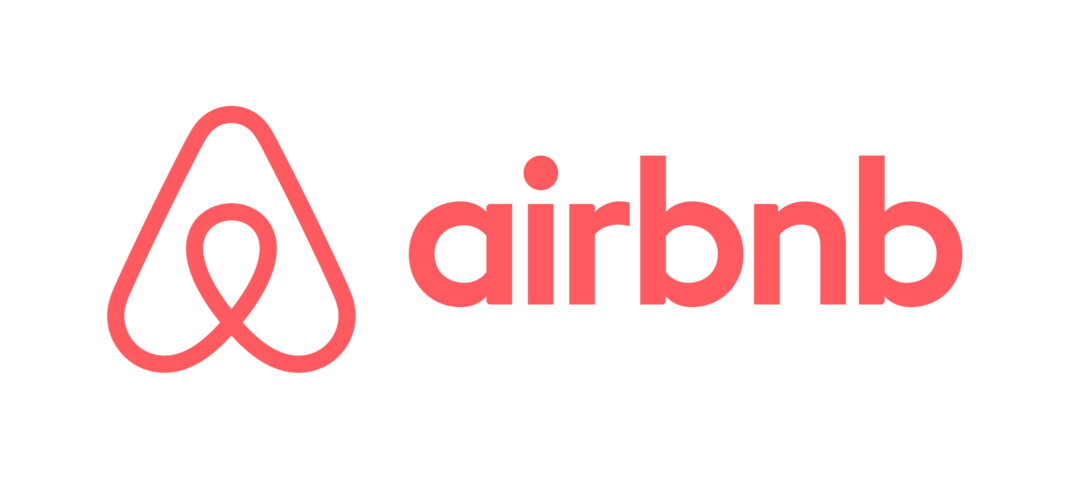

In [3]:
Image('img/airbnb.png')

<h1>Airbnb New User Bookings</h1>

<h3>Where will a new guest book their first travel experience?<h/3>

Instead of waking to overlooked "Do not disturb" signs, Airbnb travelers find themselves rising with the birds in a whimsical treehouse, having their morning coffee on the deck of a houseboat, or cooking a shared regional breakfast with their hosts.

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this business problem, Airbnb launched a challenge to predict in which country a new user will make his or her first booking.

<h3>Understanding the business problem</h3><br>

 - Problem Propose:
 
      - Prediction of the first destination a new user will choose.
            
            
  - What kind of Airbnb business model?
 
      - Marketplace (Connect people offering accommodation with people looking for accommodation)

<h1>Index</h1>

 - 0.0. IMPORTS
 - 1.0. DATA DESCRIPTION
 - 2.0. DATA FILTERING
 - 3.0. EXPLORATORY DATA ANALYSIS
 - 4.0. DATA PREPARATION
 - 5.0. FEATURE SELECTION
 - 6.0. MACHINE LEARNING MODELLING
 - 7.0. HYPERPARAMETER FINE TUNING
 - 8.0. TRANSLATION AND MODEL'S INTERPERTATION
 - 9.0 MODEL DEPLOY TO PREDICTION

# 0.0. IMPORTS

In [2]:
import warnings
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns

from random                  import choices

from IPython.core.display    import HTML
from IPython.display         import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import OneHotEncoder
from sklearn.metrics         import accuracy_score, balanced_accuracy_score
from sklearn.metrics         import cohen_kappa_score, classification_report

from scikitplot.metrics      import plot_confusion_matrix

from keras import models     as ml
from keras import layers     as l

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [70]:
df_raw = pd.read_csv('data/training_users.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [80]:
df_session = pd.read_csv('data/sessions.csv', low_memory=True)
df_session.shape

(10567737, 6)

# 1.0. DATA DESCRIPTION

In [72]:
df1 = df_raw.copy()

In [58]:
df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1. Data Dimesion

In [9]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 213451
Number of columns: 16


In [81]:
print(f'Number of rows: {df_session.shape[0]}')
print(f'Number of columns: {df_session.shape[1]}')

Number of rows: 10567737
Number of columns: 6


<br/>

In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

<h2>File descriptions</h2>

**train_users.csv** - the training set of users<br>
**test_users.csv** - the test set of users
 - id: user id
 - date_account_created: the date of account creation
 - timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  - date_first_booking because a user can search before signing up
 - date_first_booking: date of first booking
 - gender
 - age
 - signup_method
 - signup_flow: the page a user came to signup up from
 - language: international language preference
 - affiliate_channel: what kind of paid marketing
 - affiliate_provider: where the marketing is e.g. google, craigslist, other
 - first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
 - signup_app
 - first_device_type
 - first_browser
 - country_destination: this is the target variable you are to predict

**sessions.csv** - web sessions log for users
 - user_id: to be joined with the column 'id' in users table
 - action
 - action_type
 - action_detail
 - device_type
 - secs_elapsed

**countries.csv** - summary statistics of destination countries in this dataset and their locations<br>
**age_gender_bkts.csv** - summary statistics of users' age group, gender, country of destination<br>
**sample_submission.csv** - correct format for submitting your predictions

 - Data Source: https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/overview <br/>

## 1.2. Data Types

In [10]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [82]:
df_session.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. Check N/A's

In [73]:
df1.isna().sum() / len( df1 )

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [84]:
df_session.isna().sum() / len( df_session )

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4. Fillout N/A's

In [78]:
# date_first_booking
date_first_booking_max = pd.to_datetime( df1['date_first_booking'] ).max().strftime( '%Y-%m-%d' ) 
df1['date_first_booking'] = df1['date_first_booking'].fillna( date_first_booking_max )

# age
average_age = df1['age'].mean().astype( int )
df1['age'] = df1['age'].fillna( average_age )

# first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [79]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

## 1.5. Change Data Type

In [13]:
# date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( int )

In [77]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## 1.6. Data Description

In [15]:
df1.columns

Index(['id', 'date_account_created', 'timestamp_first_active',
       'date_first_booking', 'gender', 'age', 'signup_method', 'signup_flow',
       'language', 'affiliate_channel', 'affiliate_provider',
       'first_affiliate_tracked', 'signup_app', 'first_device_type',
       'first_browser', 'country_destination'],
      dtype='object')

In [16]:
df1['gender'].value_counts()

FEMALE       29863
MALE         26168
-unknown-    11979
OTHER          161
Name: gender, dtype: int64

In [17]:
# value_counts in percentage for each country
df1['country_destination'].value_counts( normalize=True ).round(4) * 100

US       70.89
other    11.09
FR        5.41
IT        2.98
GB        2.59
ES        2.49
CA        1.57
DE        1.25
NL        0.88
AU        0.64
PT        0.23
Name: country_destination, dtype: float64

# 2.0. DATA FILTERING

In [18]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 4.0. FEATURE SELECTION

In [19]:
df3 = df2.copy()

In [20]:
df3_dummy = pd.get_dummies( df3.drop( ['id', 'country_destination'], axis=1 ) )
df3 = pd.concat( [df3[['id', 'country_destination']], df3_dummy ], axis=1 )

In [21]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
df4 = df3.drop( cols_drop , axis=1 )

In [22]:
X = df4.drop( 'country_destination', axis=1 )
y = df4['country_destination'].copy()

In [23]:
# split dataset into training and test
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=32 )

# 5.0. MACHINE LEARNING MODEL

In [24]:
# dropping id column
x_train = X_train.drop( 'id', axis=1 )
x_test = X_test.drop( 'id', axis=1 )

## 5.1. Baseline Model

In [25]:
population = df1['country_destination'].drop_duplicates().sort_values().tolist()

In [26]:
weights = df1['country_destination'].value_counts( normalize=True ).sort_index().to_list()

In [27]:
k_num = y_test.shape[0]

In [28]:
yhat_random = choices( population=population, weights=weights, k=k_num )

Accuracy: 0.52%
Balanced Accuracy: 0.09%
Kappa Score: -0.002%
              precision    recall  f1-score   support

          AU       0.01      0.01      0.01       101
          CA       0.04      0.04      0.04       214
          DE       0.01      0.01      0.01       170
          ES       0.02      0.02      0.02       345
          FR       0.04      0.05      0.04       710
          GB       0.02      0.02      0.02       344
          IT       0.03      0.03      0.03       423
          NL       0.01      0.01      0.01       128
          PT       0.00      0.00      0.00        36
          US       0.71      0.71      0.71      9624
       other       0.11      0.11      0.11      1540

    accuracy                           0.52     13635
   macro avg       0.09      0.09      0.09     13635
weighted avg       0.52      0.52      0.52     13635



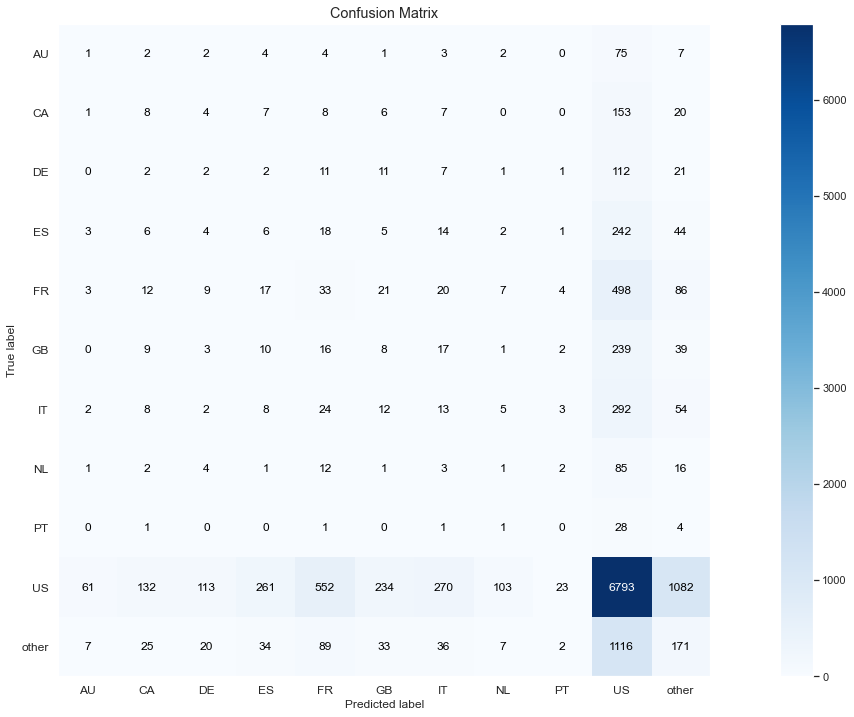

In [29]:
# Accuracy
accuracy_random = accuracy_score( y_test, yhat_random )
print(f'Accuracy: {accuracy_random:.2f}%')

# Balanced Accuracy
balanced_accuracy_random = balanced_accuracy_score( y_test, yhat_random )
print(f'Balanced Accuracy: {balanced_accuracy_random:.2f}%')

# Kappa Score
kappa_random = cohen_kappa_score( y_test, yhat_random )
print(f'Kappa Score: {kappa_random:.3f}%')

# Classification Report
print( classification_report( y_test, yhat_random ) )

# Confusion Matrix
plot_confusion_matrix( y_test, yhat_random, normalize=False );

## 5.2. Neural Network - MLP

In [30]:
# One Hot Encoder
one_hot_encod = OneHotEncoder()
y_train_nn = one_hot_encod.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [31]:
# model definition
model = ml.Sequential()
model.add( l.Dense( 128 ,input_dim=x_train.shape[1], activation='relu' ) )
model.add( l.Dense( 11, activation='softmax' ) )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam' , metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

Epoch 1/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.3289 - accuracy: 0.7030
Epoch 2/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2514 - accuracy: 0.7079
Epoch 3/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2239 - accuracy: 0.7083
Epoch 4/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.2082 - accuracy: 0.7084
Epoch 5/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1782 - accuracy: 0.7087
Epoch 6/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1680 - accuracy: 0.7087
Epoch 7/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1558 - accuracy: 0.7087
Epoch 8/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1476 - accuracy: 0.7087
Epoch 9/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1404 - accuracy: 0.7089
Epoch 10/100
1705/1705 [==============================] - 2s 1ms/step - l

1705/1705 [==============================] - 2s 1ms/step - loss: 1.1010 - accuracy: 0.7116
Epoch 77/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1001 - accuracy: 0.7117
Epoch 78/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1008 - accuracy: 0.7119
Epoch 79/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1001 - accuracy: 0.7117
Epoch 80/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0997 - accuracy: 0.7118
Epoch 81/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.0995 - accuracy: 0.7118
Epoch 82/100
1705/1705 [==============================] - 3s 2ms/step - loss: 1.1002 - accuracy: 0.7118
Epoch 83/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0994 - accuracy: 0.7119
Epoch 84/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.0989 - accuracy: 0.7118
Epoch 85/100
1705/1705 [==============================] - 2s 1ms/step - loss:

### 5.2.1. NN PERFORMANCE

In [32]:
# prediction
y_test_nn = model.predict( x_test )

# invert 
yhat_nn = one_hot_encod.inverse_transform( y_test_nn )

# prediction preparation
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]

In [33]:
# Accuracy
accuracy_nn = accuracy_score( y_test_nn, yhat_nn )
print(f'Accuracy: {accuracy_nn:.2f}%')

# Balanced Accuracy
balanced_accuracy_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
print(f'Balanced Accuracy: {balanced_accuracy_nn:.2f}%')

# Kappa Score
kappa_nn = cohen_kappa_score( y_test_nn, yhat_nn )
print(f'Kappa Score: {kappa_nn:.3f}%')

Accuracy: 0.70%
Balanced Accuracy: 0.09%
Kappa Score: 0.001%


In [34]:
# Classification Report
print( classification_report( y_test_nn, yhat_nn ) )

              precision    recall  f1-score   support

          AU       0.00      0.00      0.00       101
          CA       0.00      0.00      0.00       214
          DE       0.20      0.01      0.01       170
          ES       0.00      0.00      0.00       345
          FR       0.00      0.00      0.00       710
          GB       0.00      0.00      0.00       344
          IT       0.00      0.00      0.00       423
          NL       0.00      0.00      0.00       128
          PT       0.00      0.00      0.00        36
          US       0.71      1.00      0.83      9624
       other       0.15      0.00      0.01      1540

    accuracy                           0.70     13635
   macro avg       0.10      0.09      0.08     13635
weighted avg       0.52      0.70      0.58     13635



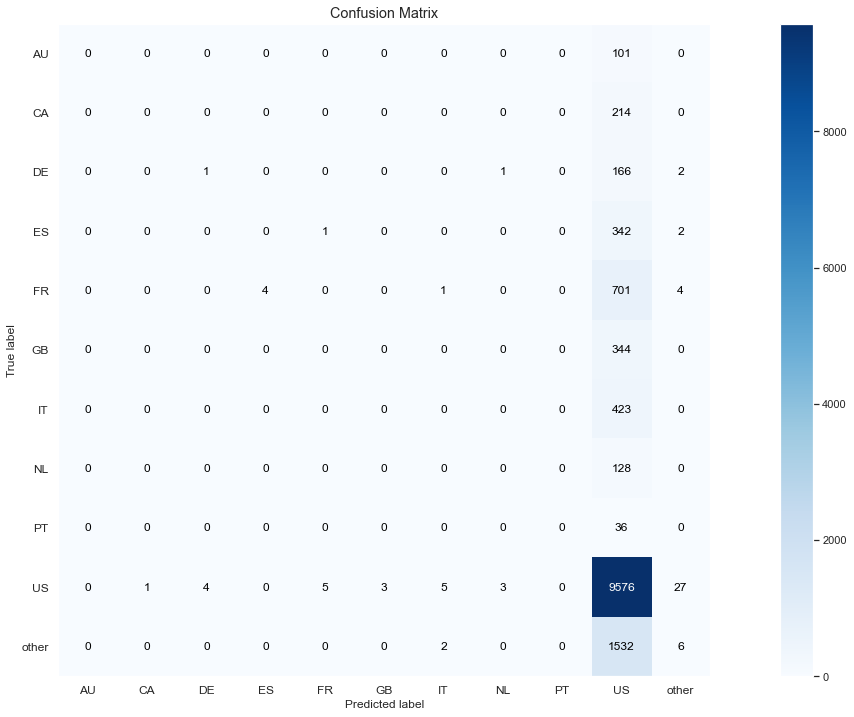

In [35]:
# Confusion Matrix
plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False );

### 5.2.2. NN PERFORMANCE - Cross Validation

In [49]:
# generate kfold
n_folds = 5
kfold = StratifiedKFold( n_splits=n_folds, shuffle=True, random_state=32 )
balanced_accuracy_nn_list = []
kappa_score_list = []
i = 1

for train_ix, val_ix in kfold.split( x_train, y_train ):
    print(f'Kfold Number: {i}/{n_folds}')

    # get kfold
    x_train_fold = x_train.iloc[ train_ix ]
    y_train_fold = y_train.iloc[ train_ix ]
    
    x_val_fold = x_train.iloc[ val_ix ]
    y_val_fold = y_train.iloc[ val_ix ]

    # One Hot Encoder
    one_hot_encoder = OneHotEncoder()
    y_train_fold_nn = one_hot_encoder.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # Model Definition
    model = ml.Sequential()
    model.add( l.Dense( 256, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 11, activation='softmax' ) )

    # Compile
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # Training
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=False )

    # Prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = one_hot_encoder.inverse_transform( pred_nn )
    
    # Data preparation
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # Metrics
    ## Balanced Accuracy
    balanced_accuracy_nn = balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_accuracy_nn_list.append( balanced_accuracy_nn )

    ## Kappa Score
    kappa_score_nn = cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_score_list.append( kappa_score_nn )
    
    i += 1


Kfold Number: 1/5
Kfold Number: 2/5
Kfold Number: 3/5
Kfold Number: 4/5
Kfold Number: 5/5


In [98]:
print(f'Average Balanced Accuracy: { round(np.mean( balanced_accuracy_nn_list ), 2 ) } +/- { round(np.std( balanced_accuracy_nn_list ), 3)  }')

Average Balanced Accuracy: 0.09 +/- 0.001


In [96]:
print(f'Average Kappa Score: { round(np.mean( kappa_score_list ), 3) } +/- { round(np.std( kappa_score_list ), 3) }')

Average Kappa Score: 0.003 +/- 0.001
